In [3]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
sns.set_style('white')
sys.path.insert(0, '../')
sys.path.insert(0, '../MIMIC_notebooks/')
pd.options.mode.chained_assignment = None

from gpu_utils import restrict_GPU_pytorch
from mimic_helper_fs import get_icd_code_long_title
from fig_helpers import add_metrics_to_df, adjust_box_widths
from km.Kernel_MPE_grad_threshold import wrapper as ramaswamy
restrict_GPU_pytorch('1')

orig = sns.color_palette('colorblind')
method_colors = [orig[2], orig[0], orig[1], orig[3], orig[4]]
method_colors = ['#4daf4a', '#e41a1c', '#377eb8', '#ff7f00', '#984ea3']
hue_order = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
plotted_methods = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
method_name_dict = {"supervised": "Supervised", "negative": "Negative", "scar-c": "SCAR-C",
                    'scar-km2': 'KM2', "sar-em": "EM", "ours": "PURPLE"}
val_loss_key = 'auprc'

Using GPU:1


<ipython-input-5-dfd5ab4de262>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])
<ipython-input-5-dfd5ab4de262>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])


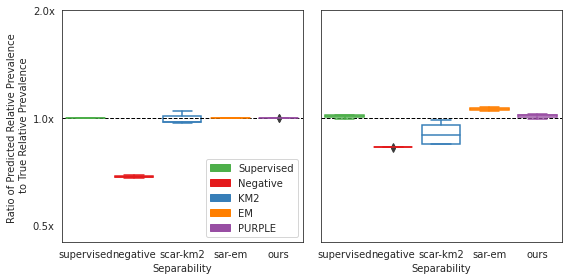

In [5]:
separability_1d_results_df = pd.concat([pd.read_csv('results/separability_scar-km2_results_1d'),
                            pd.read_csv('results/separability_ours_results_1d'),
                            pd.read_csv('results/separability_supervised_results_1d'),
                            pd.read_csv('results/separability_sar-em_results_1d'),
                            pd.read_csv('results/separability_negative_results_1d')])
separability_1d_results_df = add_metrics_to_df(separability_1d_results_df)
from matplotlib import ticker
import matplotlib.patches as mpatches

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
modes = ['separable', 'overlap']
for i, mode in enumerate(modes):
    
    our_results = separability_1d_results_df[separability_1d_results_df['method'] == 'ours']
    other_results = separability_1d_results_df[separability_1d_results_df['method'] != 'ours']
    our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run', 'separability_assumption']).head(1)
    expmt_results = pd.concat([our_results, other_results])
    expmt_results = expmt_results[expmt_results['separability_assumption'] == mode]
    
    g = sns.boxplot(x='method', y='rel_prior_err_pct', 
                     data=expmt_results, 
                     order=plotted_methods, ax=axs[i], zorder=2)
    axs[i].set_xlabel("Separability")
    axs[i].axhline(y=1.0, color='black', linestyle='--', zorder=1,
                   linewidth=1)
    if i == 0:
        axs[i].set_ylabel("Ratio of Predicted Relative Prevalence \n to True Relative Prevalence")
    else:
        axs[i].set_ylabel("")
    for j,box in enumerate(axs[i].artists):
        color = method_colors[j]
        box.set_edgecolor(color)
        box.set_facecolor('white')
        for k in range(6*j,6*(j+1)):
             axs[i].lines[k].set_color(color)
    g.set_yscale('log', base=2)
    axs[i].set_ylim([.45, 2.0])
    axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])

# Make legend
patches = []
for method_name, method_color in zip(plotted_methods, method_colors):
    patches.append(mpatches.Patch(color=method_color, label=method_name))
labels = [method_name_dict[m] for m in plotted_methods]
axs[0].legend(handles = patches, labels = labels,loc = 'lower right')
plt.tight_layout()

# Symptom Lists

In [13]:
# Endometriosis ICD codes + suspicious symptoms
from mimic_paths import hosp_diagnoses_path, english_names_path
english_names = pd.read_csv(english_names_path)
corr_path = "../data/semisynthetic/corr/endometriosis/0/"
high_rp_path = "../data/semisynthetic/high_rp/0/"
ipv_path = "../data/semisynthetic/ipv/0/"
random_path = "../data/semisynthetic/random/1/"
real_ipv_path = "../data/real_true_labels/hospital/" + "ipv" + "/0/"
def get_suspicious_code_names(f_path, english_names):
    feat_names = np.loadtxt(f_path + 'feat_names', dtype='str')
    true_clf_weights = np.loadtxt(f_path + 'true_clf_weights')
    codes = [feat_names[i] for i in np.where(true_clf_weights > 0)[0]]
    titles = []
    code_title_pairs = []
    for code in codes:
        title = get_icd_code_long_title(english_names, code)
        code_title_pairs.append((code, title))
    return code_title_pairs

random_code_title_pairs = get_suspicious_code_names(random_path, english_names)
ipv_code_title_pairs = get_suspicious_code_names(ipv_path, english_names)
corr_code_title_pairs = get_suspicious_code_names(corr_path, english_names)
high_rp_code_title_pairs = get_suspicious_code_names(high_rp_path, english_names)


In [5]:
#  Table S1
random_symptoms_df = pd.DataFrame(random_code_title_pairs, columns=['ICD Code', 'ICD Code Description'])
print(random_symptoms_df.to_latex(escape=False,  index=False,))

\begin{tabular}{ll}
\toprule
ICD Code &                               ICD Code Description \\
\midrule
    2724 &               Other and unspecified hyperlipidemia \\
    2859 &                                Anemia, unspecified \\
   30000 &                         Anxiety state, unspecified \\
     412 &                          Old myocardial infarction \\
   41401 &  Coronary atherosclerosis of native coronary ar... \\
   42731 &                                Atrial fibrillation \\
     496 &  Chronic airway obstruction, not elsewhere clas... \\
    5849 &                  Acute kidney failure, unspecified \\
    E039 &                        Hypothyroidism, unspecified \\
    E669 &                               Obesity, unspecified \\
    F419 &                      Anxiety disorder, unspecified \\
     I10 &                   Essential (primary) hypertension \\
   I4891 &                    Unspecified atrial fibrillation \\
    N179 &                  Acute kidney failure, un

In [ ]:
# Table S2
high_rp_symptoms_df = pd.DataFrame(high_rp_code_title_pairs, columns=['ICD Code', 'ICD Code Description'])
print(high_rp_symptoms_df.to_latex(escape=False,  index=False,))

In [ ]:
# Table S3
endo_disease_codes = ['N80','N800','N801','N802', 'N803', 'N804',
                      'N805', 'N806', 'N808', 'N809', '6179']
endo_disease_df = []
for code in endo_disease_codes:
    title = get_icd_code_long_title(english_names, code)
    endo_disease_df.append((code, title))
endo_disease_df = pd.DataFrame(endo_disease_df, columns=['ICD Code', 'ICD Code Description'])
print(endo_disease_df.to_latex(escape=False, index=False))

In [45]:
# Table S4
corr_symptoms_df = pd.DataFrame(corr_code_title_pairs, columns=['ICD Code', 'ICD Code Description'])
print(corr_symptoms_df.to_latex(escape=False,  index=False,))

\begin{tabular}{ll}
\toprule
ICD Code &                               ICD Code Description \\
\midrule
   33819 &                                   Other acute pain \\
    5951 &                      Chronic interstitial cystitis \\
    6205 & Torsion of ovary, ovarian pedicle, or fallopian... \\
    6260 &                            Absence of menstruation \\
   78902 &                Abdominal pain, left upper quadrant \\
   78904 &                Abdominal pain, left lower quadrant \\
   78905 &                        Abdominal pain, periumbilic \\
    7891 &                                       Hepatomegaly \\
    C561 &                  Malignant neoplasm of right ovary \\
    D251 &                     Intramural leiomyoma of uterus \\
    D252 &                     Subserosal leiomyoma of uterus \\
    D259 &                   Leiomyoma of uterus, unspecified \\
    D270 &                     Benign neoplasm of right ovary \\
     E43 &    Unspecified severe protein-calorie mal

In [47]:
#  Table S5
ipv_symptoms_df = pd.DataFrame(ipv_code_title_pairs, columns=['ICD Code', 'ICD Code Description'])
print(ipv_symptoms_df.to_latex(escape=False,  index=False,))

\begin{tabular}{ll}
\toprule
ICD Code &                               ICD Code Description \\
\midrule
    7842 &           Swelling, mass, or lump in head and neck \\
    9100 & Abrasion or friction burn of face, neck, and sc... \\
     920 &   Contusion of face, scalp, and neck except eye(s) \\
   95901 &                           Head injury, unspecified \\
 S0003XA &              Contusion of scalp, initial encounter \\
 S0011XA & Contusion of right eyelid and periocular area, ... \\
 S0012XA & Contusion of left eyelid and periocular area, i... \\
 S0990XA &      Unspecified injury of head, initial encounter \\
\bottomrule
\end{tabular}



In [10]:
# Table S6

# You would think this would work since it works for the other experiments - not true!
# It doesn't work because the feature space *excludes* any ICD codes used to identify positive cases.
# This means feat_names doesn't actually correspond to the classifier weights, so this function
# doesn't work. Leaving here in case anyone wonders.
# real_ipv_code_title_pairs = get_suspicious_code_names(real_ipv_path, english_names)
# real_ipv_symptoms_df = pd.DataFrame(real_ipv_code_title_pairs, columns=['ICD Code', 'ICD Code Description'])
# print(real_ipv_symptoms_df.to_latex(escape=False,  index=False,))

codes = ['E9672','E9673','E9671','E9670','E9679','V6111',
 '99581','99585','T7411XA','T7411XD','T7411XS','99580','T7611','T7611XA','T7611XD','T7611XS',
         'T7611XA', 'T7611XD','T7611XS','Y070','Y0701','Y0702','Y0703','Y0704','Y079']
code_title_pairs = []
for code in codes:
    title = get_icd_code_long_title(english_names, code)
    code_title_pairs.append((code, title))
real_ipv_symptoms_df = pd.DataFrame(code_title_pairs, columns=['ICD Code', 'ICD Code Description'])
print(real_ipv_symptoms_df.to_latex(escape=False,  index=False,))

\begin{tabular}{ll}
\toprule
ICD Code &                               ICD Code Description \\
\midrule
   20410 &  Chronic lymphoid leukemia, without mention of ... \\
   41402 &  Coronary atherosclerosis of autologous vein by... \\
   43310 &  Occlusion and stenosis of carotid artery witho... \\
   53085 &                                Barrett's esophagus \\
    5569 &                    Ulcerative colitis, unspecified \\
    8730 &  Open wound of scalp, without mention of compli... \\
   K2270 &              Barrett's esophagus without dysplasia \\
   V1051 &  Personal history of malignant neoplasm of bladder \\
    V422 &                 Heart valve replaced by transplant \\
   V4581 &                        Aortocoronary bypass status \\
\bottomrule
\end{tabular}



# Table versions of synthetic & semisynthetic graphs.

In [48]:
col_name_dict = {"supervised": "Supervised", "negative": "Negative", "scar-c": "SCAR-C",
                    'scar-km2': 'KM2', "sar-em": "EM", "ours": "PURPLE"}

val_loss_key = 'auprc'
group_gap_results_df = pd.concat([pd.read_csv('results/group_gap_supervised_results'),
                            pd.read_csv('results/group_gap_ours_results'),
                            pd.read_csv('results/group_gap_scar-km2_results'),
                            pd.read_csv('results/group_gap_sar-em_results'),
                            pd.read_csv('results/group_gap_negative_results')])

label_freq_results_df = pd.concat([pd.read_csv('results/label_freq_scar-km2_results'),
                            pd.read_csv('results/label_freq_ours_results'),
                            pd.read_csv('results/label_freq_supervised_results'),
                            pd.read_csv('results/label_freq_sar-em_results'),
                            pd.read_csv('results/label_freq_negative_results')])

separability_results_df = pd.concat([pd.read_csv('results/separability_scar-km2_results'),
                            pd.read_csv('results/separability_ours_results'),
                            pd.read_csv('results/separability_supervised_results'),
                            pd.read_csv('results/separability_sar-em_results'),
                            pd.read_csv('results/separability_negative_results')])

ipv_our_results = pd.read_csv('results/ipv_ours_semisimulated_results')
ipv_our_results = ipv_our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run']).head(1)
ipv_results_df = pd.concat([pd.read_csv('results/ipv_sar-em_semisimulated_results'),
                        pd.read_csv('results/ipv_supervised_semisimulated_results'),
                        pd.read_csv('results/ipv_cdmm_semisimulated_results'),
                        pd.read_csv('results/ipv_scar-km2_semisimulated_results'),
                        pd.read_csv('results/ipv_negative_semisimulated_results'),
                        ipv_our_results], ignore_index=True)

random_our_results = pd.read_csv('random_ours_semisimulated_results')
random_our_results = random_our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run']).head(1)
random_results_df = pd.concat([pd.read_csv('results/random_supervised_semisimulated_results'),
                        pd.read_csv('results/random_scar-km2_semisimulated_results'),
                        pd.read_csv('results/random_sar-em_semisimulated_results'),
                        random_our_results,
                        pd.read_csv('results/random_negative_semisimulated_results')], ignore_index=True)

corr_our_results = pd.read_csv('results/corr4_ours_semisimulated_results')
corr_our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run']).head(1)
corr_results_df = pd.concat([pd.read_csv('results/corr4_supervised_semisimulated_results'),
                        pd.read_csv('results/corr4_scar-km2_semisimulated_results'),
                        pd.read_csv('results/corr4_sar-em_semisimulated_results'),
                        corr_our_results,
                        pd.read_csv('results/corr4_negative_semisimulated_results')], 
                        ignore_index=True)

def produce_mean_std_df(results_df,  expmt_key, expmt_col_name):
    means = results_df.groupby(['method', expmt_key]).mean().reset_index()
    stds =  results_df.groupby(['method', expmt_key]).std().reset_index()
    means['pred_rel_prior_std'] = stds['pred_rel_prior'].round(2).map('{:.2f}'.format)
    means['pred_rel_prior_mean'] = means['pred_rel_prior'].round(2).map('{:.2f}'.format)
    means['pred_rel_prior_mean_std'] = "$" + means['pred_rel_prior_mean'] + '±' + means['pred_rel_prior_std'] + "$"
    subset = means[['method', expmt_key, 'pred_rel_prior_mean_std']]
    subset['method_pretty_name'] = subset['method'].map(col_name_dict)

    xx = subset.pivot_table(values='pred_rel_prior_mean_std', index=[expmt_key], columns='method_pretty_name', aggfunc='first')
    xx = xx.reset_index()
    xx[expmt_col_name] = xx[expmt_key]
    xx = xx[[expmt_col_name, 'Negative', 'KM2', 'EM', 'PURPLE', 'Supervised']]

    table_str = xx.to_latex(escape=False, index=False )
    table_str = table_str.replace('±','\pm')
    return table_str


In [49]:
print(produce_mean_std_df(group_gap_results_df, 'group_gap', 'Group Gap'))

\begin{tabular}{rlllll}
\toprule
 Group Gap &    Negative &         KM2 &          EM &      PURPLE &  Supervised \\
\midrule
     -2.00 & $1.40\pm0.00$ & $1.25\pm0.08$ & $2.40\pm0.05$ & $1.92\pm0.03$ & $1.89\pm0.03$ \\
     -1.00 & $1.03\pm0.01$ & $1.17\pm0.21$ & $1.42\pm0.02$ & $1.32\pm0.02$ & $1.32\pm0.01$ \\
     -0.50 & $1.04\pm0.00$ & $1.19\pm0.03$ & $1.18\pm0.02$ & $1.12\pm0.01$ & $1.15\pm0.01$ \\
     -0.25 & $1.08\pm0.00$ & $1.06\pm0.10$ & $1.07\pm0.02$ & $1.05\pm0.01$ & $1.06\pm0.01$ \\
      0.00 & $1.12\pm0.00$ & $1.09\pm0.11$ & $1.00\pm0.01$ & $1.00\pm0.00$ & $0.99\pm0.01$ \\
\bottomrule
\end{tabular}



In [50]:
separability_results_df = separability_results_df[separability_results_df['separability_assumption'].isin(['overlap', 'separable'])]
print(produce_mean_std_df(separability_results_df, 'separability_assumption', 'Separability Setting'))

\begin{tabular}{llllll}
\toprule
Separability Setting &    Negative &         KM2 &          EM &      PURPLE &  Supervised \\
\midrule
             overlap & $1.40\pm0.01$ & $1.25\pm0.07$ & $2.47\pm0.05$ & $1.90\pm0.03$ & $1.92\pm0.02$ \\
           separable & $1.86\pm0.01$ & $2.22\pm0.23$ & $3.12\pm0.04$ & $3.11\pm0.03$ & $3.08\pm0.00$ \\
\bottomrule
\end{tabular}



In [51]:
expmt_key = 'labeling_frequency_g2'
expmt_col_name = 'c_{g_b}'
means = corr_results_df.groupby(['method', expmt_key]).mean().reset_index()
stds =  corr_results_df.groupby(['method', expmt_key]).std().reset_index()
means['pred_rel_prior_std'] = stds['pred_rel_prior'].round(2).map('{:.2f}'.format)
means['pred_rel_prior_mean'] = means['pred_rel_prior'].round(2).map('{:.2f}'.format)
means['pred_rel_prior_mean_std'] = means['pred_rel_prior_mean'] + '±' + means['pred_rel_prior_std']
subset = means[['method', expmt_key, 'pred_rel_prior_mean_std']]
subset['method'] = subset['method'].map(col_name_dict)

xx = subset.pivot_table(values='pred_rel_prior_mean_std', index=[expmt_key], columns='method', aggfunc='first')
xx = xx.reset_index()
xx[expmt_col_name] = xx[expmt_key]
xx = xx[[expmt_col_name, 'Negative', 'KM2', 'EM', 'PURPLE', 'Supervised']]

table_str = xx.to_latex(escape=False, index=False )
table_str = table_str.replace('±','\pm')


In [52]:
print(produce_mean_std_df(label_freq_results_df, 'labeling_frequency_g2', 'c_{g_b}'))

\begin{tabular}{rlllll}
\toprule
 c_{g_b} &    Negative &         KM2 &          EM &      PURPLE &  Supervised \\
\midrule
     0.1 & $1.37\pm0.01$ & $1.36\pm0.23$ & $2.30\pm0.08$ & $1.92\pm0.04$ & $1.89\pm0.03$ \\
     0.3 & $1.40\pm0.02$ & $1.37\pm0.16$ & $2.46\pm0.07$ & $1.93\pm0.03$ & $1.93\pm0.03$ \\
     0.5 & $1.43\pm0.00$ & $1.43\pm0.12$ & $2.50\pm0.03$ & $1.93\pm0.02$ & $1.92\pm0.01$ \\
     0.7 & $1.47\pm0.01$ & $1.14\pm0.05$ & $2.50\pm0.03$ & $1.93\pm0.03$ & $1.94\pm0.02$ \\
     0.9 & $1.51\pm0.01$ & $1.25\pm0.14$ & $2.50\pm0.04$ & $1.92\pm0.02$ & $1.94\pm0.02$ \\
\bottomrule
\end{tabular}



# Semi-synthetic results

In [53]:
print(produce_mean_std_df(random_results_df, 'labeling_frequency_g2', 'c_{g_b}'))

\begin{tabular}{rlllll}
\toprule
 c_{g_b} &    Negative &         KM2 &          EM &      PURPLE &  Supervised \\
\midrule
     0.1 & $4.02\pm0.14$ & $5.09\pm0.77$ & $1.67\pm0.06$ & $0.84\pm0.01$ & $0.85\pm0.01$ \\
     0.3 & $1.33\pm0.05$ & $1.62\pm0.00$ & $0.91\pm0.02$ & $0.85\pm0.03$ & $0.85\pm0.02$ \\
     0.5 & $0.81\pm0.03$ & $0.79\pm0.12$ & $0.72\pm0.01$ & $0.86\pm0.02$ & $0.86\pm0.02$ \\
     0.7 & $0.60\pm0.02$ & $0.51\pm0.04$ & $0.68\pm0.02$ & $0.85\pm0.01$ & $0.86\pm0.03$ \\
     0.9 & $0.44\pm0.02$ & $0.40\pm0.03$ & $0.63\pm0.01$ & $0.84\pm0.01$ & $0.85\pm0.02$ \\
\bottomrule
\end{tabular}



In [55]:
print(produce_mean_std_df(corr_results_df, 'labeling_frequency_g2', 'c_{g_b}'))

\begin{tabular}{rlllll}
\toprule
 c_{g_b} &    Negative &         KM2 &          EM &      PURPLE &  Supervised \\
\midrule
     0.1 & $5.13\pm0.54$ & $1.00\pm0.00$ & $2.33\pm0.19$ &         NaN & $1.05\pm0.03$ \\
     0.3 & $1.65\pm0.12$ & $1.00\pm0.00$ & $1.25\pm0.04$ & $1.89\pm0.27$ & $1.07\pm0.03$ \\
     0.5 & $1.03\pm0.05$ & $1.00\pm0.00$ & $0.81\pm0.02$ &         NaN & $1.04\pm0.04$ \\
     0.7 & $0.73\pm0.03$ & $1.00\pm0.00$ & $0.69\pm0.02$ &         NaN & $1.06\pm0.04$ \\
     0.9 & $0.56\pm0.03$ & $0.34\pm0.00$ & $0.58\pm0.04$ &         NaN & $1.05\pm0.03$ \\
\bottomrule
\end{tabular}



In [56]:
print(produce_mean_std_df(ipv_results_df, 'labeling_frequency_g2', 'c_{g_b}'))

\begin{tabular}{rlllll}
\toprule
 c_{g_b} &    Negative &         KM2 &          EM &      PURPLE &  Supervised \\
\midrule
     0.1 & $4.73\pm0.30$ & $1.00\pm0.00$ & $3.25\pm0.43$ & $0.97\pm0.01$ & $0.94\pm0.12$ \\
     0.3 & $1.58\pm0.06$ & $1.00\pm0.00$ & $1.37\pm0.48$ & $0.95\pm0.01$ & $0.94\pm0.07$ \\
     0.5 & $0.95\pm0.06$ & $1.00\pm0.00$ & $0.78\pm0.15$ & $0.95\pm0.02$ & $0.94\pm0.08$ \\
     0.7 & $0.69\pm0.03$ & $0.47\pm0.29$ & $0.64\pm0.14$ & $0.94\pm0.01$ & $0.91\pm0.10$ \\
     0.9 & $0.51\pm0.01$ & $0.34\pm0.00$ & $0.50\pm0.08$ & $0.95\pm0.01$ & $0.92\pm0.10$ \\
\bottomrule
\end{tabular}

